<a href="https://colab.research.google.com/github/RaianaSeixas/Data_Science_Otimization_OR/blob/main/Testes/01_Detec%C3%A7%C3%A3o_de_anomalias_m12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição do problema
Este notebook tem como objetivo o uso de machine learning para detectar anomalias relativas a ordens de vendas de uma grande empresa norte americana.

Anomalias são alterações dentro de um padrão de dados, valores atípicos, desvios de algo esperado. A detecção de anomalias no contexto do comércio pode ser feita com diferentes objetivos, tais como limpeza de dados, detecção de problemas na qualidade dos produtos,   de fraudes, de falhas de preço ou de alterações anormais na sazonalidade.

Várias técnicas de ML podem ser usadas para dectectar anomalias no caso de não termos dados de anomalia rotulados (como no exemplo que será aqui resolvido), entre elas,  técnicas baseadas em densidade (que presumem que os pontos nominais estão relativamente próximos uns dos outros, enquanto as anomalias estão mais distantes), técnicas baseadas em clusterização (que presumem que anomalias são quaisquer pontos que estejam fora dos clusters "k") e técnicas baseadas em predição de séries temporais (nas quais dados do passado são usados para criar um modelo capaz de prever eventos no futuro).

Como neste exemplo temos uma sequência de valores coletados no tempo, optamos por construir um modelo de previsão de séries temporais e compará-lo, com uso de técnicas estatísticas, com os dados reais, a fim de identificar anomalias.

Outra abordagem utilizada foi usar o método Isolation Forest, que é uma técnica similar ao Randon Forest, que constroi Árvores de Decisão que fazem partições aleatórias dos dados para isolar anomalias.

-----------------------

**Observação**: Para o código funcionar é necessário interagir com ele 2 vezes. No início, restart runtime logo após a instalação do Pycaret (caso contrário haverá um erro na importação dessa biblioteca), e segundo, ao final, apertar um enter confirmando a detecção automática das variáveis do Pycaret (até essa confirmação ser feita, o código fica em espera).


----------------------------------
Autor: Raiana Roland Seixas

22/07/2022


# Instalar e importar bibliotecas

In [1]:
# Pycaret (Usado para Isolation Forest)
!pip install pycaret --user 
!pip install markupsafe==2.0.1
import jinja2
from pycaret.anomaly import * # anomaly detection module

# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from matplotlib import pyplot
import seaborn as sns
import math

# Bliotecas usada no modelo de série temporal
import statsmodels.api as sm
import statsmodels.tsa.api as smt
!pip install pmdarima #otimizaçao de parâmetros
from pmdarima import auto_arima

#from sklearn.metrics import mean_squared_error
#from matplotlib import pyplot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 17.3 MB/s 
     |████████████████████████████████| 9.8 MB 49.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Inspeção dos dados

In [2]:
#clonar do Github
!git clone https://github.com/RaianaSeixas/Data_Science_Otimization_OR.git
%cd Data_Science_Otimization_OR/Data

Cloning into 'Data_Science_Otimization_OR'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 50 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/Data_Science_Otimization_OR/Data


In [3]:
df=pd.read_excel('sample.xlsx')

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Não há dados ausentes no conjunto de dados.

In [6]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


#Análise Exploratória

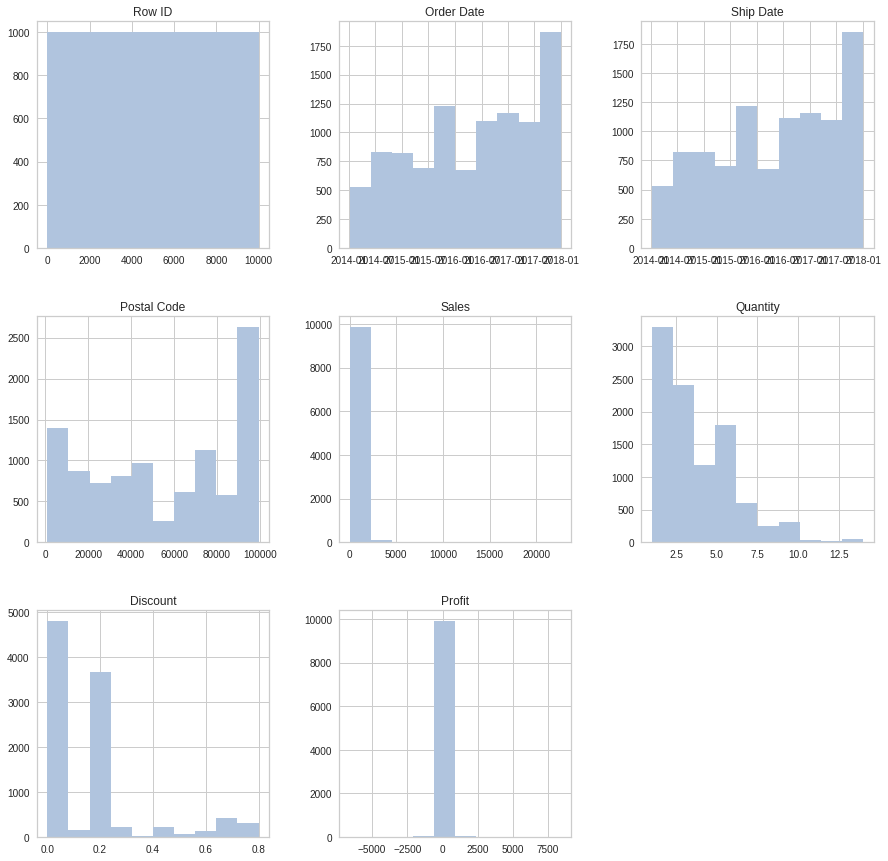

In [7]:
# Distribuíção de frequências das variáveis
df.hist(figsize=(15,15),color='lightsteelblue');
#df.hist()

In [8]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [9]:
#Ordenação crescente dos dados por data
df=df.sort_values(by='Order Date', ascending=True)

Text(0.5, 1.0, 'Vendas ao longo do tempo')

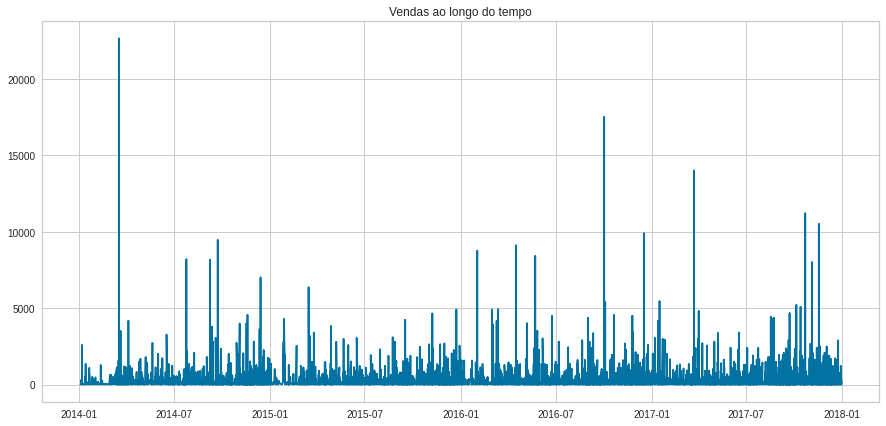

In [10]:
plt.rcParams['figure.figsize'] = [15, 7] #mudar área do gráfico
plt.plot(df['Order Date'],df['Sales'])
plt.title('Vendas ao longo do tempo')

Text(0.5, 1.0, 'Lucro ao longo do tempo')

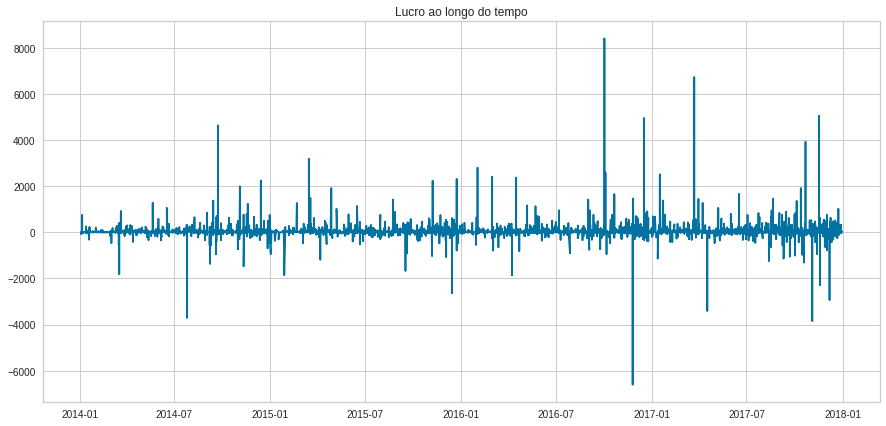

In [11]:
plt.plot(df['Order Date'],df['Profit'])
plt.title('Lucro ao longo do tempo')

Text(0.5, 1.0, 'Quantidade de produtos vendidos ao longo do tempo')

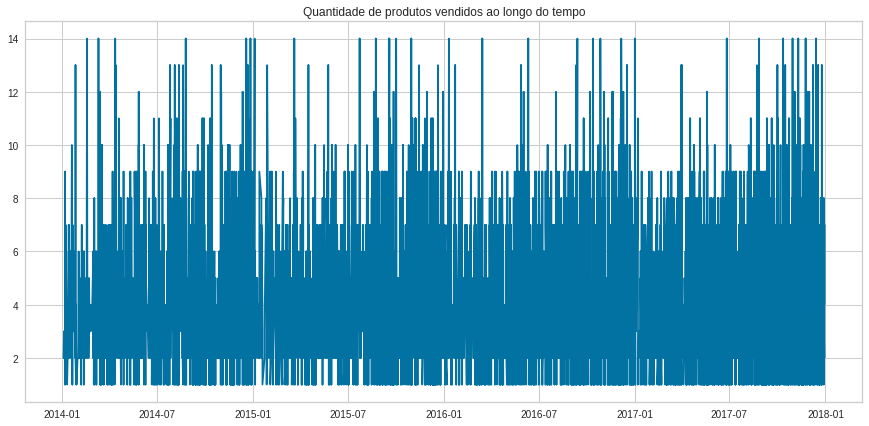

In [12]:
plt.plot(df['Order Date'],df['Quantity'])
plt.title('Quantidade de produtos vendidos ao longo do tempo')

Faremos os boxplots para melhor entender a distribuíção dos atributos numéricos e gráficos de coluna para melhor compreender os atributos categóricos.

In [13]:
plt.rcParams['figure.figsize'] = [10, 7]

Text(0.5, 1.0, 'Boxplot Variável Vendas')

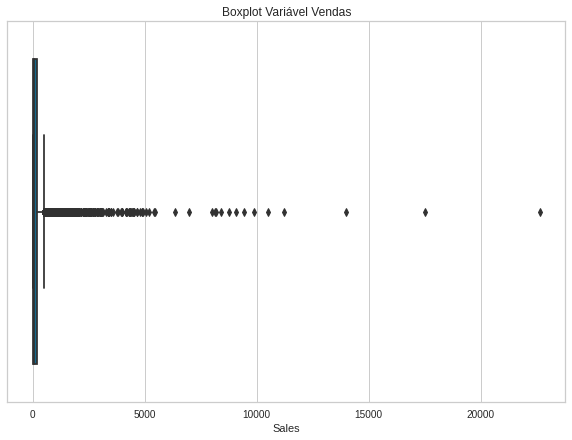

In [14]:
sns.boxplot(df['Sales'])
plt.title('Boxplot Variável Vendas')

Ao observar tanto o histograma, quanto o boxplot para a variável Vendas (Sales), nota-se que os dados estão bastante enviesados a direita. Logo a transformação log é uma opção interessante.

Text(0.5, 1.0, 'Boxplot Variável Quantidade')

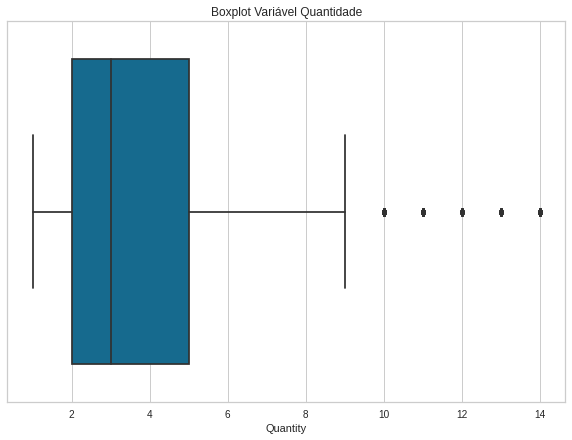

In [15]:
sns.boxplot(df['Quantity'])
plt.title('Boxplot Variável Quantidade')

Text(0.5, 1.0, 'Boxplot Variável Desconto')

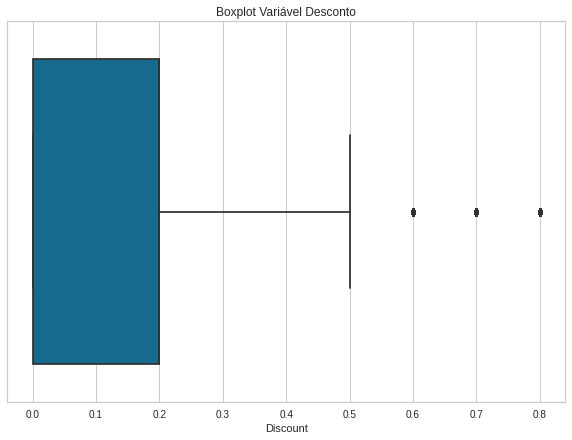

In [16]:
sns.boxplot(df['Discount'])
plt.title('Boxplot Variável Desconto')

Text(0.5, 1.0, 'Boxplot Variável Lucro')

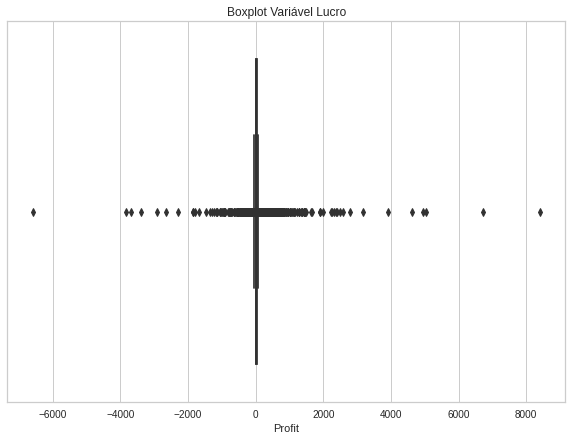

In [17]:
sns.boxplot(df['Profit'])
plt.title('Boxplot Variável Lucro')

Text(0.5, 1.0, 'Ordens por Segmento')

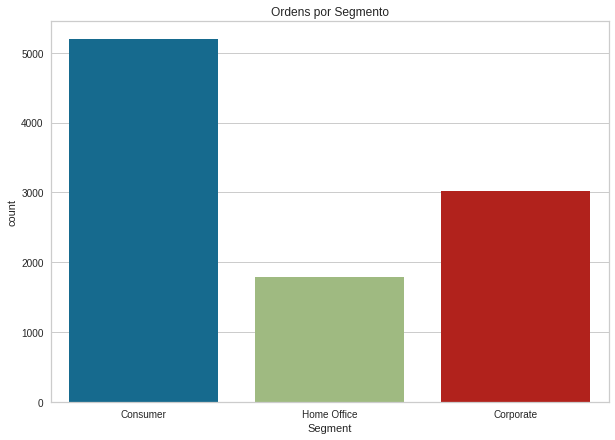

In [18]:
sns.countplot(df['Segment'])
plt.title('Ordens por Segmento')

Text(0.5, 1.0, 'Ordens por modo de entrega')

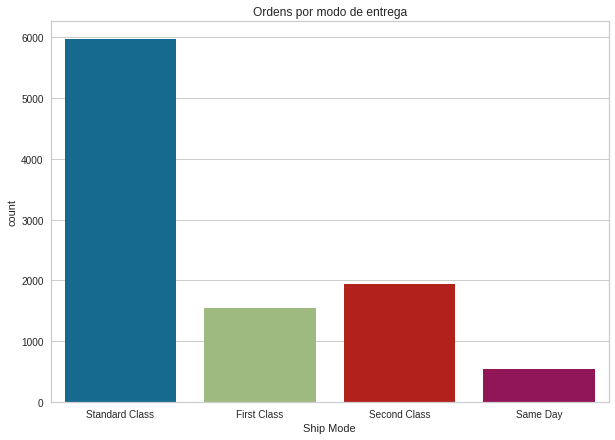

In [19]:
sns.countplot(df['Ship Mode'])
plt.title('Ordens por modo de entrega')

Text(0.5, 1.0, 'Ordens por País')

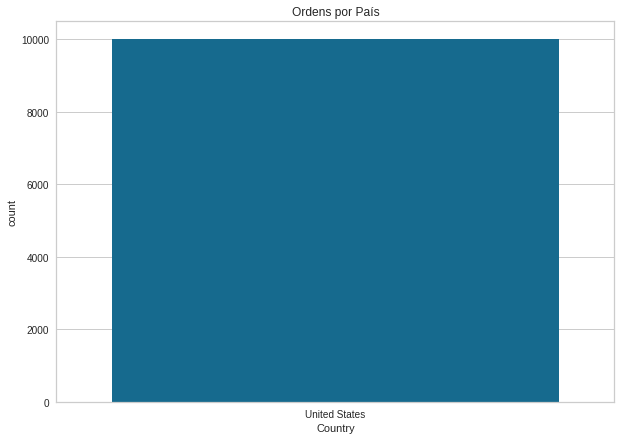

In [20]:
sns.countplot(df['Country'])
plt.title('Ordens por País')

Text(0.5, 1.0, 'Ordens por Região')

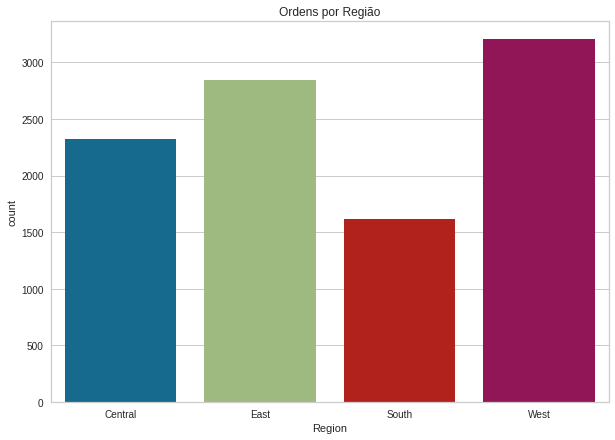

In [21]:
sns.countplot(df['Region'])
plt.title('Ordens por Região')

In [22]:
print('Ordens por Cidade')
df['City'].describe()

Ordens por Cidade


count              9994
unique              531
top       New York City
freq                915
Name: City, dtype: object

Text(0.5, 1.0, 'Ordens por Estado')

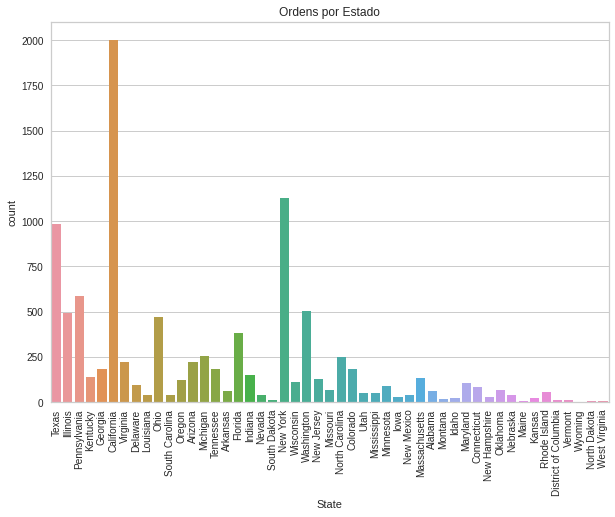

In [23]:
sns.countplot(df['State'])
xticks(rotation = 90)
plt.title('Ordens por Estado')

Text(0.5, 1.0, 'Ordens por Categoria do produto')

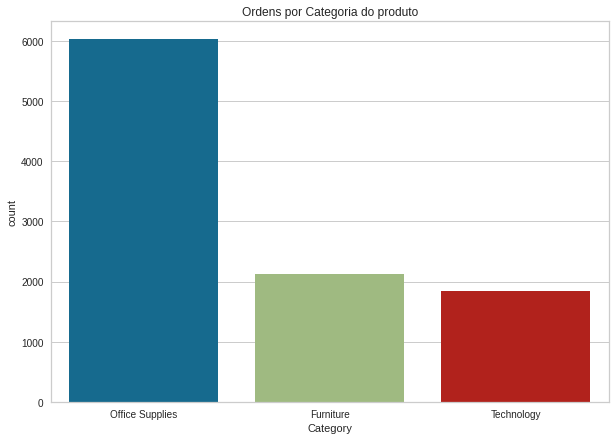

In [24]:
sns.countplot(df['Category'])
plt.title('Ordens por Categoria do produto')

Text(0.5, 1.0, 'Ordens por Subcategoria do produto')

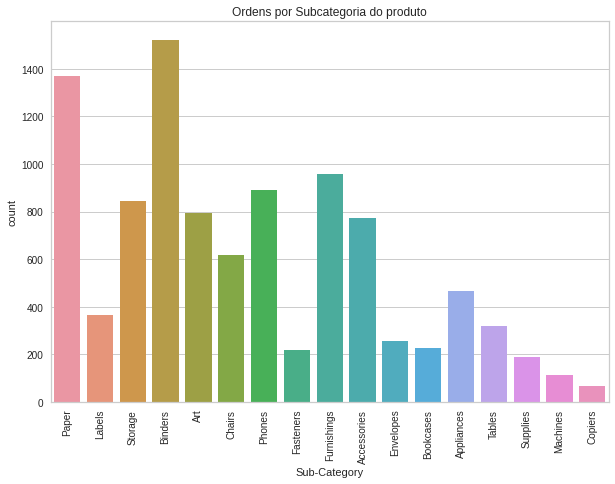

In [25]:
sns.countplot(df['Sub-Category'])
xticks(rotation = 90)
plt.title('Ordens por Subcategoria do produto')

In [26]:
df['Customer Name'].describe()

count              9994
unique              793
top       William Brown
freq                 37
Name: Customer Name, dtype: object

# Detecção de anomalias

## Detecção de anomalias por comparação com predição de série temporal

Vamos usar o  SARIMA, que gera modelos AutoRegressivos Integrados de Médias Móveis com Sazonalidade. Uma sugesatão de melhoria seria explorar melhor o tipo de modelo a ser usado.

### Agrupamento dos dados considerando as vendas semanais
Sem agrupamento, não é possível identificar os padrões, e o agrupamento mensal reduz muito o número de amostras.

In [27]:
office_suplies = df.loc[df['Category'] == 'Office Supplies']
office_suplies = office_suplies.groupby('Order Date')['Sales'].sum().reset_index()
office_suplies = office_suplies.set_index('Order Date')
#y = office_suplies['Sales'].resample('MS').mean()
#y = office_suplies['Sales'].resample('B').mean()
y = office_suplies['Sales'].resample('W').mean()
y = y.reset_index()

In [28]:
y.head()

,Order Date,Sales
0,2014-01-05,108.014667
1,2014-01-12,177.001000
2,2014-01-19,584.441000
3,2014-01-26,381.056667
4,2014-02-02,92.196000


In [29]:
y.shape

(209, 2)

In [30]:
# Extração os valores e aplicação da transformação de log para estabilizar a variação nos dados ou para torná-los estacionários antes de alimentá-los ao modelo.

In [31]:
yactual_vals = y.Sales.values
actual_log = np.log10(yactual_vals)

In [32]:
N =int(y.shape[0]*0.3) # 70% treino / 30% teste

In [33]:
train, test = yactual_vals[0:-N], yactual_vals[-N:]

In [34]:
train_log, test_log = np.log10(train), np.log10(test) # transformação log

my_order = (1, 1, 1) # (AR specification, Integration order, MA specification) - ordem não sazonal
my_seasonal_order = (0, 1, 1, 7) #(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity) - ordem sazonal

# Esses parâmetros foram escolhidos sem muito critério, pois serão otimizados em etapa posterior 

In [35]:
train.shape, test.shape

((147,), (62,))

In [36]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(train_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    
    model_fit = model.fit()
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = train_log[t]
    history.append(obs)
  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


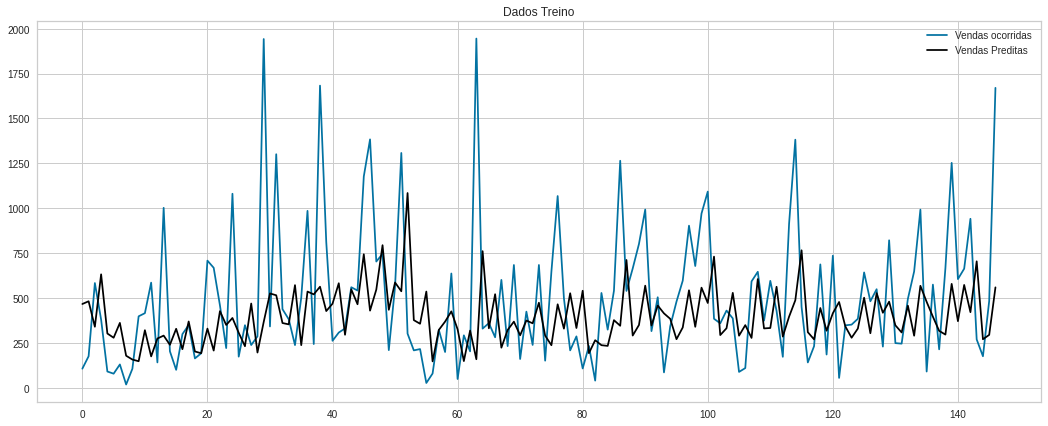

In [37]:
# plot
figsize=(18, 7)
plt.figure(figsize=figsize)
pyplot.plot(train,label='Vendas ocorridas')
pyplot.plot(predictions, color='black',label='Vendas Preditas')
pyplot.legend(loc='upper right')
pyplot.title('Dados Treino')
pyplot.show()

In [38]:
# parte do teste
history = [x for x in test_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    
    model_fit = model.fit()
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)

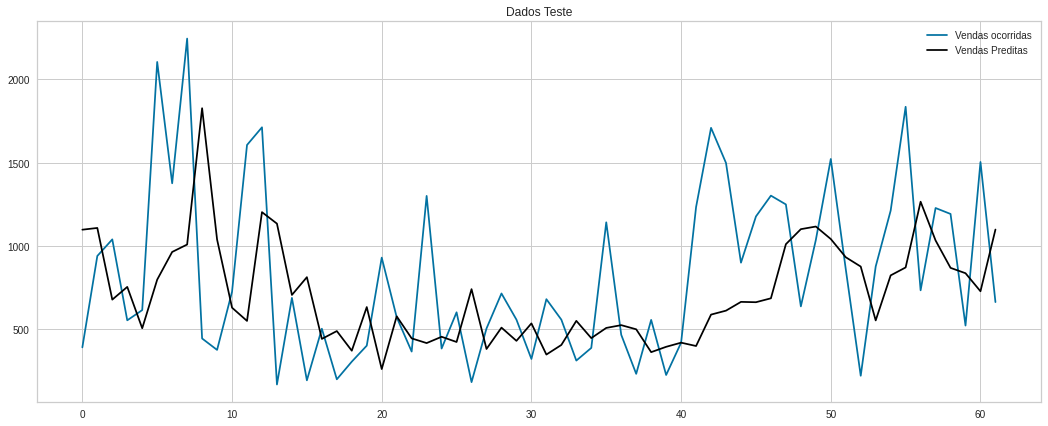

In [39]:
# plot
figsize=(18, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Vendas ocorridas')
pyplot.plot(predictions, color='black',label='Vendas Preditas')
pyplot.legend(loc='upper right')
pyplot.title('Dados Teste')
pyplot.show()

Os gráficos mostrando as vendas reais versus predito tanto para treino como para teste, indicam que o modelo foi capaz de capturar uma tendência geral, porém há vários valores discrepantes ( o que pode também ocorrer devido a anomalias)

In [40]:
# Avaliação da qualidade

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  123
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                 -25.460
Date:                           Thu, 28 Jul 2022   AIC                             58.920
Time:                                   01:20:44   BIC                             69.574
Sample:                                        0   HQIC                            63.238
                                           - 123                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0354      0.165      0.215      0.830      -0.287       0.358
ma.L1         -0.8088      0.092     -8.769      0.000      -0.990      -0.628
ma.S.L7       -1.0000    243.942     -0.004      0.997    -479.117     477.117
sigma2         0.0821     20.010      0.004      0.997     -39.137      39.301
===================================================================================
Ljung-Box (Q):                       46.84   Jarque-Bera (JB):                 4.41
Prob(Q):                              0.21   Prob(JB):                         0.11
Heteroskedasticity (H):               0.78   Skew:                            -0.50
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Os p-valores altos para alguns coeficientes, indicam pouca significância dessas partes do modelo. Vamos tentar melhorar os valores via otimização.

### Otimização do modelo

In [41]:
stepwise_model = auto_arima(train_log, start_p=1, start_q=1,
                           max_p=12, max_q=12, m=12,
                           max_P=12, max_Q=12, max_order=12,  seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=254.746, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=202.192, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=151.628, Time=0.67 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=186.195, Time=0.23 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=5.16 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=170.243, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=6.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=152.606, Time=0.89 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=152.845, Time=0.94 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=155.319, Time=1.71 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=153.320, Time=

In [42]:
# Modelo com os dados otimizados

history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(train_log)):
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = train_log[t]
    history.append(obs)


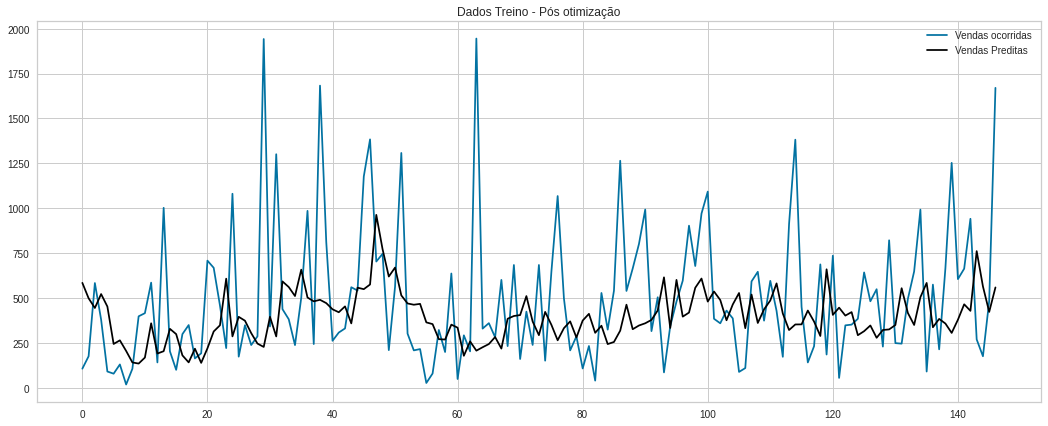

In [43]:
# plot
figsize=(18, 7)
plt.figure(figsize=figsize)
pyplot.plot(train,label='Vendas ocorridas')
pyplot.plot(predictions, color='black',label='Vendas Preditas')
pyplot.legend(loc='upper right')
pyplot.title('Dados Treino - Pós otimização')
pyplot.show()

In [44]:
# Modelo com os dados otimizados

history = [x for x in test_log]
#predictions = list()
#predict_log=list()
predictions_test = list()
predict_log_test=list()
for t in range(len(test_log)):
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    predictions_test.append(yhat)
    obs = test_log[t]
    history.append(obs)

In [45]:
y['Sales'].shape

(209,)

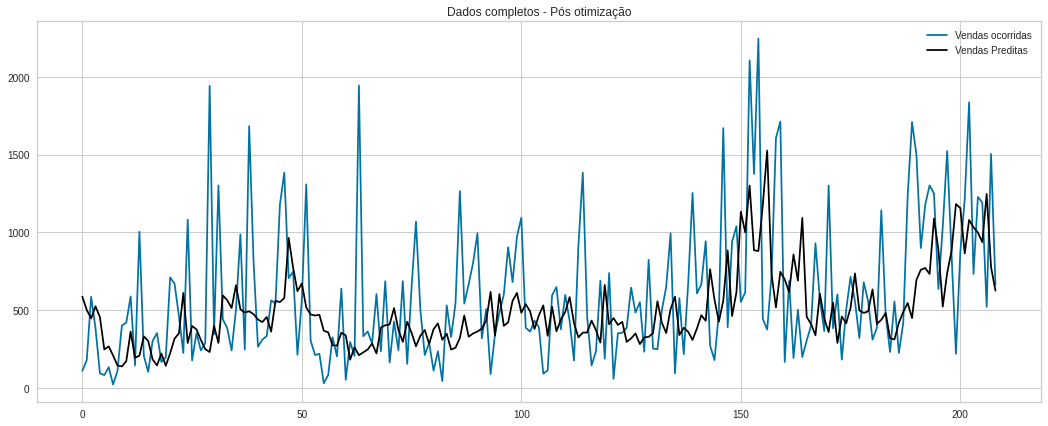

In [46]:
# plot
figsize=(18, 7)
plt.figure(figsize=figsize)
pyplot.plot(y['Sales'],label='Vendas ocorridas')
pyplot.plot(predictions, color='black',label='Vendas Preditas')
pyplot.legend(loc='upper right')
pyplot.title('Dados completos - Pós otimização')
pyplot.show()

In [47]:
stepwise_model.fit(history).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  124
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -33.278
Date:                            Thu, 28 Jul 2022   AIC                             72.557
Time:                                    01:24:36   BIC                             80.685
Sample:                                         0   HQIC                            75.854
                                            - 124                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8177      0.060    -13.633      0.000      -0.935      -0.700
ma.S.L12      -0.9199      0.252     -3.646      0.000      -1.414      -0.425
sigma2         0.0880      0.022      4.068      0.000       0.046       0.130
===================================================================================
Ljung-Box (Q):                       51.24   Jarque-Bera (JB):                 6.21
Prob(Q):                              0.11   Prob(JB):                         0.04
Heteroskedasticity (H):               0.74   Skew:                            -0.58
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

O modelo após otimização, parece um pouco melhor, porém ainda apresenta coeficientes pouco significativos, mesmo considerando que essas méticas foram calculadas com os dados de treino e teste em conjunto. Como trabalho futuro sugere-se estudar melhor a forma de definir parâmetros para o método Sarima e rodar o modelo após a eliminação de possíveis anomalias para verificar se após a eclusão de alguns pontos atípicos é possível obter um modelo mais aderente as dados reais.


In [48]:
time_series_df = y
predicted_df=pd.DataFrame()
predicted_df['Order Date']=time_series_df['Order Date']
predicted_df['Sales']=y['Sales']
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df['error']= predicted_df['Sales'].values - predicted_df['predicted'].values
predicted_df.head()

,Order Date,Sales,predicted,error
0,2014-01-05,108.014667,585.334886,-477.320219
1,2014-01-12,177.001000,499.675371,-322.674371
2,2014-01-19,584.441000,445.709497,138.731503
3,2014-01-26,381.056667,523.066658,-142.009992
4,2014-02-02,92.196000,453.701801,-361.505801


In [49]:
predicted_df.shape

(209, 4)

### Diferentes critérios de definir anomalia

In [50]:
''' Detecção de anomalias considerando IQR ( Distância interquartílica) '''

error = predicted_df['error'].values
Q1 = np.percentile(error, 25)
Q3 = np.percentile(error, 75)
IQR = Q3- Q1
upper = Q3 +1.5*IQR
lower = Q3 -1.5*IQR
status =[]
for valor in error:
  if (valor > upper  ):
    status.append(1)
  elif( valor < lower ):
    status.append(1)
  else:
    status.append(0)

#plt.scatter(predicted_df['Order Date'],status)

In [51]:
predicted_df['anomaly_IQR']= status
anomaly = predicted_df[predicted_df['anomaly_IQR'] == 1]

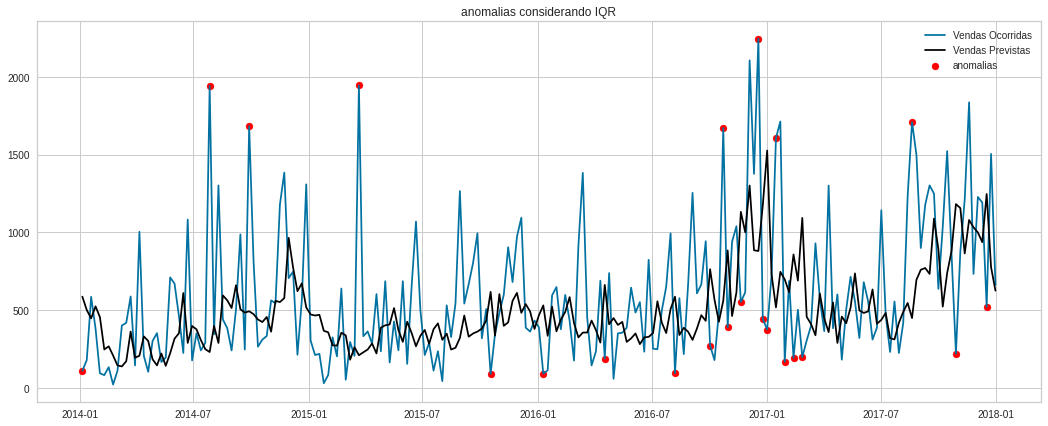

In [52]:
plt.rcParams['figure.figsize'] = [18, 7] #mudar área do gráfico
x = predicted_df['Order Date']
y = predicted_df['Sales']
y1 = anomaly['Sales']
x1 =anomaly['Order Date']
y2= predicted_df['predicted'] 
plt.plot(x,y,label='Vendas Ocorridas')
plt.plot(x,y2,'black',label='Vendas Previstas')
plt.scatter(x1,y1, color = 'red',label='anomalias')
plt.legend()
plt.title('anomalias considerando IQR')
plt.show()

In [53]:
''' Porcentagem de anomalias - critério IQR para definir anomalia '''

num=predicted_df['anomaly_IQR'].sum() # número de anomalias
anomaly_p=num/predicted_df.shape[0]*100 # porcentagem anomalias
print('Porcentagem de anomalias: ',anomaly_p)

Porcentagem de anomalias:  10.526315789473683


In [54]:
''' Anomalias considerando z-score '''
# Considera como anomalia os ponto em que os erros (real - predito) são maiores em módulo do que 2 desvios padrões em relação à média de erros

error = predicted_df['error'].values
lower = np.mean(error)-2.0*np.std(error)
upper = np.mean(error)+2.0*np.std(error)
status =[]
for valor in error:
  if (valor > upper  ):
    status.append(1)
  elif( valor < lower ):
    status.append(1)
  else:
    status.append(0)

#plt.scatter(predicted_df['Order Date'],status)

In [55]:
predicted_df['anomaly 2s']= status
anomaly = predicted_df[predicted_df['anomaly 2s'] == 1]

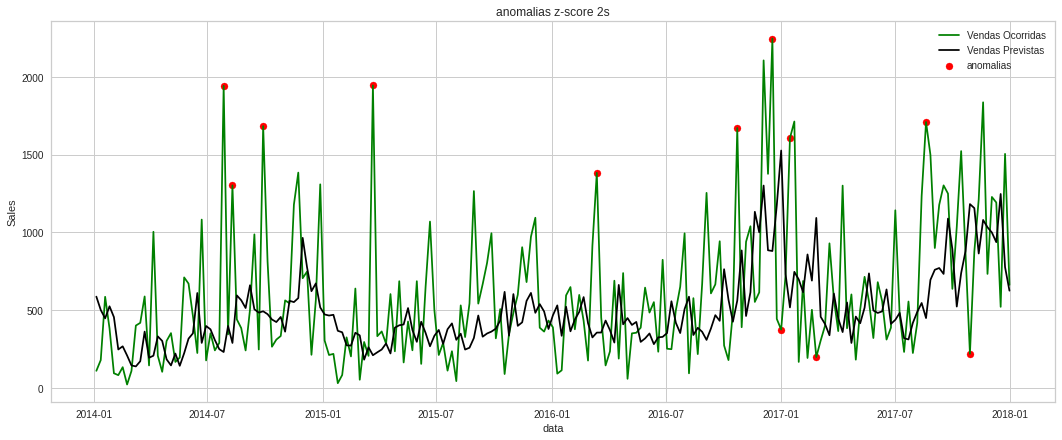

In [56]:
x = predicted_df['Order Date']
y = predicted_df['Sales']
y1 = anomaly['Sales']
x1 =anomaly['Order Date']
y2= predicted_df['predicted'] 
plt.plot(x,y,'green',label='Vendas Ocorridas')
plt.plot(x,y2,'black',label='Vendas Previstas')
plt.scatter(x1,y1, color = 'red',label='anomalias')
plt.legend()
plt.title('anomalias z-score 2s')
plt.xlabel('data')
plt.ylabel('Sales')
plt.show()

In [57]:
print(predicted_df.shape)
predicted_df.head()

(209, 6)


,Order Date,Sales,predicted,error,anomaly_IQR,anomaly 2s
0,2014-01-05,108.014667,585.334886,-477.320219,1,0
1,2014-01-12,177.001000,499.675371,-322.674371,0,0
2,2014-01-19,584.441000,445.709497,138.731503,0,0
3,2014-01-26,381.056667,523.066658,-142.009992,0,0
4,2014-02-02,92.196000,453.701801,-361.505801,0,0


In [58]:
''' Porcentagem de anomalias - critério Z-score para definir anomalia'''

num=predicted_df['anomaly 2s'].sum() # número de anomalias
anomaly_p=num/predicted_df.shape[0]*100 # porcentagem anomalias
print('Porcentagem de anomalias: ',anomaly_p)

Porcentagem de anomalias:  5.741626794258373


## Isolation Forest

Optei por testar a biblioteca Pycaret, uma ferramenta de auto ML para realizar essa parte do trabalho. O Pycaret faz a transformação seleção de variáveis de maneira automática, facilitando o trabalho. A Biblioteca oferece muitas funcionalidades, porém, as mesmas não foram exploradas; usou-se as configurações padrão. Como trabalho futuro faria um estudo da documentação do Pycaret de maneira a poder explorar melhor as funcionalidades.


In [59]:
''' Apertar enter na saída desta célula para confirmar o tipo de variável''' 

#Inicializar o setup
exp_ano = setup(df, log_experiment=True)

,Description,Value
0,session_id,4346
1,Original Data,"(9994, 21)"
2,Missing Values,False
3,Numeric Features,5
4,Categorical Features,14
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(9994, 10983)"
9,CPU Jobs,-1


2022/07/28 01:25:52 INFO mlflow.tracking.fluent: Experiment with name 'anomaly-default-name' does not exist. Creating a new experiment.


In [60]:
# Criação do modelo
iforest=create_model('iforest')

In [61]:
# Impressão do gráfico de anomalias
plot_model(iforest)

In [62]:
# Gerar as predições usando o modelo treinado
iforest_predictions = predict_model(iforest, data = df)

In [63]:
iforest_predictions

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Anomaly,Anomaly_Score
7980,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,0,-0.010577
739,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,0,-0.003841
740,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,0,-0.003420
741,742,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,0,-0.008026
1759,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,0,-0.005983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5091,5092,CA-2017-156720,2017-12-30,2018-01-03,Standard Class,JM-15580,Jill Matthias,Consumer,United States,Loveland,...,OFF-FA-10003472,Office Supplies,Fasteners,Bagged Rubber Bands,3.024,3,0.2,-0.6048,0,-0.008899
908,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,...,OFF-BI-10003684,Office Supplies,Binders,Wilson Jones Legal Size Ring Binders,52.776,3,0.2,19.7910,0,-0.004134
907,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,...,TEC-PH-10004774,Technology,Phones,Gear Head AU3700S Headset,90.930,7,0.0,2.7279,0,-0.006890
1296,1297,CA-2017-115427,2017-12-30,2018-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,OFF-BI-10002103,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.904,2,0.2,4.5188,0,-0.004039


In [64]:
# Porcentagem de anomalias

a=iforest_predictions['Anomaly'].sum()/iforest_predictions['Anomaly'].count()
print('% anomalias=',a*100)
print('% não anomalia=',(1-a)*100)

% anomalias= 5.003001801080648
% não anomalia= 94.99699819891934


Nota-se que a porcentagem de anomalias obtidas através do modelo Isolation Forest, que contempla todos os atributos, foi similar à % de anomalias obtidas usando a predição de séries temporais para a variável Vendas (Sales), quando o critério de definição de anomalia foi o z-score do erro de predição (considerando outlier os erros acima, em módulo, a 2 desvios padrão em relação à média de erros).